Preprocessing by removing black lines and replacing with dominant neighbouring colour, extra white space is removed too

In [46]:
#Black line removal
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def find_black_pixel_group(image, start_y, start_x, tolerance=2, visited=None):
    """
    Find all connected black pixels starting from a given pixel.
    
    Parameters:
    - image: Input image (BGR format)
    - start_y, start_x: Starting pixel coordinates
    - tolerance: Maximum deviation from black (0,0,0) to be considered black
    - visited: Set of already visited pixels (used internally for recursion)
    
    Returns:
    - List of tuples containing coordinates of all connected black pixels
    """
    if visited is None:
        visited = set()
    
    height, width = image.shape[:2]
    black_pixels = []
    stack = [(start_y, start_x)]
    
    while stack:
        y, x = stack.pop()
        
        # Skip if already visited or out of bounds
        if (y, x) in visited or y < 0 or y >= height or x < 0 or x >= width:
            continue
        
        visited.add((y, x))
        
        # Check if pixel is black (within tolerance)
        pixel = image[y, x]
        if np.all(pixel <= tolerance):
            black_pixels.append((y, x))
            
            # Add 8 neighboring pixels to stack
            for dy in [-1, 0, 1]:
                for dx in [-1, 0, 1]:
                    if dy == 0 and dx == 0:
                        continue
                    stack.append((y + dy, x + dx))
    
    return black_pixels

def get_neighboring_dominant_color_per_pixel(image, y, x, black_pixel_set, tolerance=2):
    """
    Find the dominant color from immediate neighbors of a single black pixel.
    
    Parameters:
    - image: Input image
    - y, x: Coordinates of the black pixel
    - black_pixel_set: Set of all black pixel coordinates
    - tolerance: Tolerance for black pixel detection
    
    Returns:
    - Dominant color as (B, G, R) tuple
    """
    height, width = image.shape[:2]
    neighboring_colors = []
    
    # Check all 8 immediate neighbors
    for dy in [-1, 0, 1]:
        for dx in [-1, 0, 1]:
            if dy == 0 and dx == 0:
                continue
            
            ny, nx = y + dy, x + dx
            
            # Check bounds
            if 0 <= ny < height and 0 <= nx < width:
                # Skip if it's a black pixel itself
                if (ny, nx) not in black_pixel_set:
                    pixel = image[ny, nx]
                    # Only consider non-black pixels
                    if not np.all(pixel <= tolerance):
                        neighboring_colors.append(tuple(pixel))
    
    # Find dominant color
    if neighboring_colors:
        color_counter = Counter(neighboring_colors)
        dominant_color = color_counter.most_common(1)[0][0]
        return dominant_color
    else:
        # Fallback to white if no neighboring colors found
        return (255, 255, 255)

def dominant_colour_replacement(original, all_black_groups, tolerance=2):
    result = original.copy()
    
    for i, group in enumerate(all_black_groups):
        # Create a set for fast lookup
        black_pixel_set = set(group)
        
        # Replace each pixel individually based on its own neighbors
        for y, x in group:
            dominant_color = get_neighboring_dominant_color_per_pixel(
                original, y, x, black_pixel_set, tolerance
            )
            result[y, x] = dominant_color
        
        print(f"Group {i+1}: {len(group)} pixels replaced individually")
    
    return result
# Find all black pixel groups
def find_all_black_groups(original, tolerance = 2):
    visited_global = set()
    all_black_groups = []

    for y in range(original.shape[0]):
        for x in range(original.shape[1]):
            if (y, x) not in visited_global:
                pixel = original[y, x]
                if np.all(pixel <= tolerance):
                    # Found an unvisited black pixel
                    black_group = find_black_pixel_group(original, y, x, tolerance, visited_global)
                    if black_group:
                        all_black_groups.append(black_group)
    return all_black_groups


def black_line_removal(image):
    original = image
    # Create a mask showing only black lines
    black_mask = np.ones_like(original) * 255  # Start with white background
    all_black_groups = find_all_black_groups(original)

    result = dominant_colour_replacement(original, all_black_groups)

    # Convert BGR to RGB for proper display in matplotlib
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    return result_rgb

def trim_white(image):
    # Assume image is in BGR (default for OpenCV)
    # Non-white mask: any pixel not exactly [255,255,255]
    non_white_mask = np.any(image != [255, 255, 255], axis=2)
    coords = np.argwhere(non_white_mask)
    if coords.size == 0:
        # Entire image is white
        return None
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0) + 1  # slicing is exclusive on end
    trimmed = image[y0:y1, x0:x1]
    return trimmed



# Plot comparison
# plt.figure(figsize=(30, 20))

# plt.subplot(1, 2, 1)
# plt.imshow(original_rgb)
# plt.title('Original Image')
# plt.axis('off')

# plt.subplot(1, 2, 2)
# plt.imshow(result_rgb)
# plt.title('Black Lines Removed')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

# # Save the result
# cv2.imwrite("output.png", result)
# print(f"\nResult saved as 'output.png'")
# print(f"Total black pixel groups found: {len(all_black_groups)}")
# print(f"Total black pixels removed: {sum(len(group) for group in all_black_groups)}")

In [47]:
import os
def create_clean_dataset(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Adjust as needed
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)
            
            # Read image
            image = cv2.imread(input_path)
            
            # Check image was loaded
            if image is not None:
                result = black_line_removal(image)
                result =trim_white(result)
                # Save output (convert RGB back to BGR for cv2.imwrite)
                result_bgr = cv2.cvtColor(result, cv2.COLOR_RGB2BGR)
                cv2.imwrite(output_path, result_bgr)
            else:
                print(f"Warning: Couldn't read {input_path}")

In [48]:
# run to preprocess 
# import os
# import cv2
# import numpy as np

# input_folder = './train/'
# output_folder = './preprocessed/'
#create_clean_dataset(input_folder, output_folder)

# input_folder = './test/'
# output_folder = './clean_test/'
#create_clean_dataset(input_folder, output_folder)



Simple segmentation is used, vertical white space is identified as boundary

In [49]:
#simple segmentation
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import glob

def simple_segmentation(original, size = (512, 120)):
    resized = cv2.resize(original, size)
    if len(resized.shape) == 3:
        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    else:
        gray = resized.copy()

    tolerance = 2
    _, binary = cv2.threshold(gray, 255 - tolerance, 255, cv2.THRESH_BINARY)
    vertical_projection = np.sum(binary == 0, axis=0)

    # Detect valleys: very strict zero pixel count
    valleys = []
    for i in range(1, len(vertical_projection) - 1):
        if vertical_projection[i] == 0:
            valleys.append(i)

        # Cluster valleys: merge nearby indices
    clustered_valleys = []
    if valleys:
        cluster = [valleys[0]]
        for idx in valleys[1:]:
            if idx - cluster[-1] <= 3:   # Change 3 to desired cluster width
                cluster.append(idx)
            else:
                # Use mean or center of the cluster
                clustered_valleys.append(int(np.mean(cluster)))
                cluster = [idx]
        clustered_valleys.append(int(np.mean(cluster))) # Last cluster

    return resized, clustered_valleys

def get_segments(original, size = (512, 120)):
    # Image segmentation code, returns word segment tuples
    resized, clustered_valleys = simple_segmentation(original, size)

    segments = []
    prev = 0
    for val in clustered_valleys:
        segments.append((prev, val))
        prev = val + 1
    segments.append((prev, resized.shape[1] - 1))
    return resized, segments



Colour is identified in each segment, if multiple colour is found, that means words might be stacked together and we can use Ze Rui's model. If segment only contains a singular colour we use simple segmentation

In [50]:
def rgb_to_hsv_vectorized(arr):
    """
    Convert RGB array to HSV
    arr: N x 3 array of RGB values (0-255)
    returns: N x 3 array of HSV values (H: 0-179, S: 0-255, V: 0-255)
    """
    if arr.size == 0:
        return np.array([]).reshape(0, 3)
    
    # Ensure correct shape and type
    arr = np.asarray(arr, dtype=np.uint8)
    
    if len(arr.shape) == 1:
        arr = arr.reshape(1, 3)
    
    # Reshape for cv2: needs to be (height, width, 3)
    original_shape = arr.shape
    arr_reshaped = arr.reshape(-1, 1, 3)
    
    hsv = cv2.cvtColor(arr_reshaped, cv2.COLOR_RGB2HSV)
    
    # Reshape back to N x 3
    return hsv.reshape(original_shape)

def quantize_hue(hue_values, hue_bins):
    """
    Quantize hue values into bins (e.g., 12 bins = 30° each)
    hue_values: array of hue values (0-179 in OpenCV)
    hue_bins: number of hue bins to divide the color wheel
    returns: quantized hue values
    """
    if hue_values.size == 0:
        return hue_values
    
    bin_size = 180 // hue_bins
    return ((hue_values // bin_size) * bin_size).astype(np.uint8)

def quantize_colors_hsv(arr, hue_bins, ignore_low_saturation=True, sat_threshold=5):
    """
    Quantize colors based on HSV hue
    arr: N x 3 array of RGB values
    hue_bins: number of hue bins (12 = 30° each, 24 = 15° each, etc.)
    ignore_low_saturation: if True, treat low saturation pixels as "neutral/white"
    sat_threshold: saturation threshold below which colors are considered neutral
    """
    if arr.size == 0:
        return np.array([])
    
    arr = np.asarray(arr, dtype=np.uint8)
    
    if len(arr.shape) == 1:
        arr = arr.reshape(1, 3)
    
    # Convert to HSV
    hsv = rgb_to_hsv_vectorized(arr)
    
    # Quantize hue
    quantized_hue = quantize_hue(hsv[:, 0], hue_bins)
    
    # Create a color identifier
    # If saturation is too low, mark as neutral (assign special value)
    if ignore_low_saturation:
        color_ids = np.where(hsv[:, 1] < sat_threshold, 
                            255,  # Special ID for neutral/white colors
                            quantized_hue)
    else:
        color_ids = quantized_hue
    
    return color_ids

def has_two_colors(segment_img, hue_bins=6, ignore_low_saturation=True, sat_threshold=2):
    """
    Check if segment has two or more distinct colors based on hue
    segment_img: image array (H x W x 3) or (H x W)
    hue_bins: number of hue bins for quantization
    ignore_low_saturation: treat low saturation as neutral
    sat_threshold: saturation threshold for neutral colors
    ignore_white: if True, filter out white/neutral colors before counting
    """
    # Validate input
    if segment_img is None or segment_img.size == 0:
        print("Empty image provided")
        return False
    
    segment_img = np.asarray(segment_img, dtype=np.uint8)
    
    # Reshape to N x 3
    if len(segment_img.shape) == 3:
        if segment_img.shape[2] == 3:
            seg_reshaped = segment_img.reshape(-1, 3)
        else:
            print(f"Unexpected number of channels: {segment_img.shape[2]}")
            return False
    elif len(segment_img.shape) == 2:
        # Grayscale - convert to RGB for HSV processing
        seg_reshaped = np.stack([segment_img.reshape(-1)] * 3, axis=1)
    else:
        print(f"Unexpected image shape: {segment_img.shape}")
        return False
    
    if seg_reshaped.size == 0:
        print("No pixels to process")
        return False
    
    # Get color IDs based on quantized hue
    color_ids = quantize_colors_hsv(seg_reshaped, hue_bins, ignore_low_saturation, sat_threshold)
    
    # Filter out white/neutral colors if requested
    filtered_ids = color_ids[color_ids != 255]
    
    if filtered_ids.size == 0:
        print("All pixels are white/neutral")
        return False
    
    # Count unique hue bins
    unique_colors = np.unique(filtered_ids)
    print(unique_colors)
    
    return len(unique_colors) >= 3


In [77]:
# #run to seperate complicated segments input and easy segments input
import os
import shutil

def seperate_ez_data(input, output_ez, output_hard):
    os.makedirs(output_ez, exist_ok=True)
    os.makedirs(output_hard, exist_ok=True)
    for fname in os.listdir(input):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(input, fname)
            img = cv2.imread(img_path)
            resized, segments = get_segments(img)
            hard = False
            for seg in segments:
                segment_img = resized[:, seg[0]:seg[1]+1]
                if has_two_colors(segment_img, hue_bins=6):
                    hard = True
                    break
            if not hard:
                shutil.copy2(img_path, os.path.join(output_ez, fname))
                # Display the image
                #plt.figure(figsize=(10, 6))
                # Convert BGR to RGB for proper color display
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                # plt.imshow(img_rgb)
                # plt.title(f'Hard Segment: {fname}')
                # plt.axis('off')
                # plt.tight_layout()
                # plt.show()
            else :
                shutil.copy2(img_path, os.path.join(output_hard, fname))



In [ ]:

# seperate_ez_data("./preprocessed/", "./train_ez/", "./train_hard/")
#seperate_ez_data("./clean_test/", "./test_ez/", "test_hard")

[  0  30  60 150]
[120 150]
[ 90 120]
[  0 150]
[ 90 120]
[60]
[30 60]
[30]
[ 90 120]
[120 150]
[  0 150]
[ 0 30]
[60]
[0]
[  0  90 120 150]
[ 90 120]
[  0 150]
[120]
[30]
[0]
[30]
[30]
[ 0 30]
[90]
[  0 150]
[30 60]
[150]
[30]
[150]
[90]
[  0 150]
[90]
[  0 150]
[60 90]
[ 90 120]
[0]
[ 90 120]
[90]
[ 90 120]
[30 60]
[60 90]
[ 90 120]
[90]
[90]
[120]
[ 0 30]
[120 150]
[60 90]
[120]
[90]
[30 60]
[ 90 150]
[  0 150]
[90]
[150]
[30 60]
[150]
[90]
[120 150]
[120]
[60]
[  0 150]
[120]
[120]
[60]
[30]
[0]
[0]
[60]
[  0  90 120 150]
[120 150]
[ 90 120]
[  0 150]
[ 90 120]
[ 60  90 120]
[150]
[60 90]
[150]
[60 90]
[30 60]
[30 60]
[120]
[30 60]
[ 90 120]
[ 90 120]
[30]
[150]
[60 90]
[120 150]
[  0 150]
[60]
[0]
[90]
[ 90 120]
[  0 150]
[60]
[120 150]
[60 90]
[60 90]
[30]
[120 150]
[30]
[90]
[60]
[90]
[120 150]
[90]
[30]
[0]
[60]
[0]
[ 90 120]
[0]
[30 60]
[60 90]
[  0 150]
[120]
[30 60]
[90]
[150]
[120]
[120]
[ 90 120]
[30 60]
[120 150]
[90]
[30]
[  0 150]
[30]
[120 150]
[60]
[  0  90 150]
[ 0 3

Start training, Simple CNN is used

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from glob import glob
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import re
import os
import pickle

# Define input size and number of classes
input_size = 90 * 120  # Flatten the image
num_classes = 36  # 0-9 and a-z

train_dir = './train/'
image_size = (90, 120)

# Label encoding: 0-9 and A-Z
alphanum = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
char_to_label = {c: i for i, c in enumerate(alphanum)}

def get_label_from_filename(filename):
    basename = os.path.basename(filename)
    # Extract string before "-0.png" (or similar patterns)
    match = re.match(r'(.*?)-\d+\.(png|jpg|jpeg)$', basename, re.I)
    if match:
        return match.group(1)
    else:
        return None

def labels_to_tensor(label_str):
    # Convert string label (e.g., 'ZHV1OR') to tensor of class indices
    return torch.tensor([char_to_label[c.upper()] for c in label_str if c.upper() in char_to_label], dtype=torch.long)

transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=8, translate=(0.08, 0.08), scale=(0.90, 1.10), fill=255),
    transforms.RandomApply([transforms.GaussianBlur(3)], p=0.2),
    transforms.ToTensor()
])

# Simple transform for val/test (just ToTensor)
transform_eval = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

class SegmentDataset(Dataset):
    def __init__(self, img_dir, image_size, char_to_label, transform=None):
        self.image_files = glob(os.path.join(img_dir, '*.*'))
        self.image_size = image_size
        self.char_to_label = char_to_label
        self.transform = transform

        self.samples = []
        for file in self.image_files:
            label_str = get_label_from_filename(file)
            if not label_str:
                continue
            image = cv2.imread(file)
            resized, segments = get_segments(image, (512, 120))
            if (len(segments) != len(label_str)):
                continue
            
            for idx, seg in enumerate(segments):
                segment_img = resized[:, seg[0]:seg[1]+1]
                if segment_img is None or segment_img.size == 0:
                    continue
                segment_img = cv2.cvtColor(segment_img, cv2.COLOR_BGR2GRAY)
                
                _, binary = cv2.threshold(segment_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

                segment_img = cv2.resize(binary, image_size)
                img_tensor = torch.from_numpy(segment_img).float() / 255.0
                if img_tensor.ndim == 2:
                    img_tensor = img_tensor.unsqueeze(0)
                label_tensor = char_to_label[label_str[idx].upper()]
                self.samples.append((img_tensor, label_tensor))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_tensor, label_tensor = self.samples[idx]
        if self.transform is not None:
            # Convert back to numpy, to PIL, then do augmentation
            # Ensure img_tensor is [C, H, W], float [0,1]
            img = (img_tensor.squeeze().numpy() * 255).astype(np.uint8)
            img = self.transform(img)
        else:
            img = img_tensor
        return img, label_tensor

# Define the MLP model
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool(torch.relu(self.bn4(self.conv4(x))))
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x





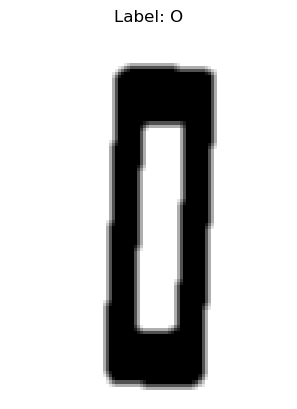

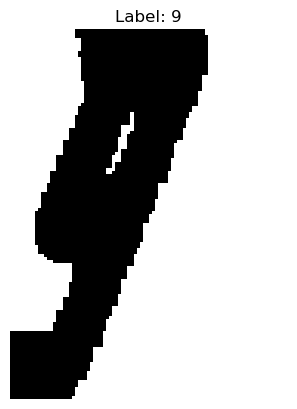

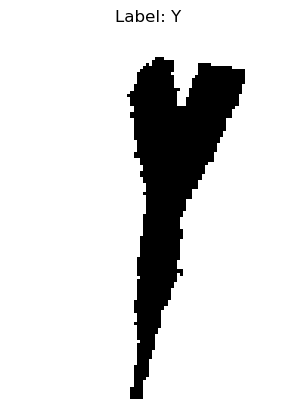

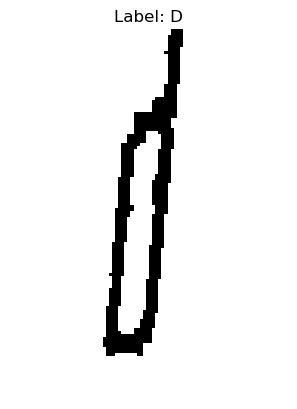

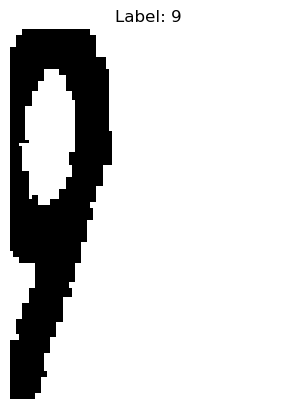

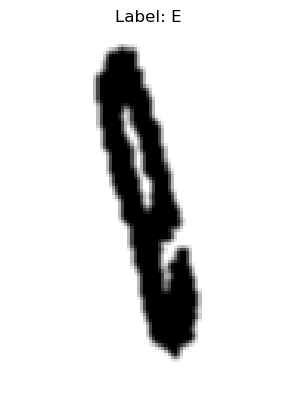

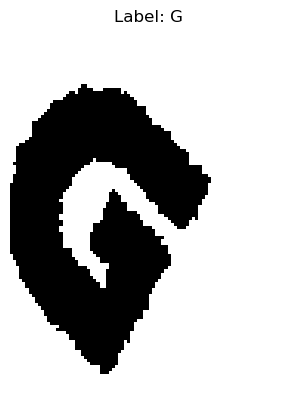

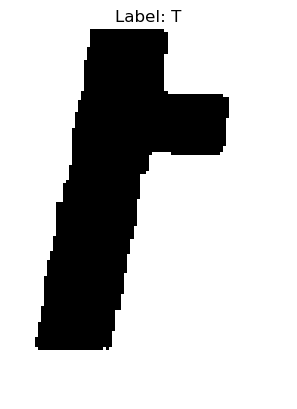

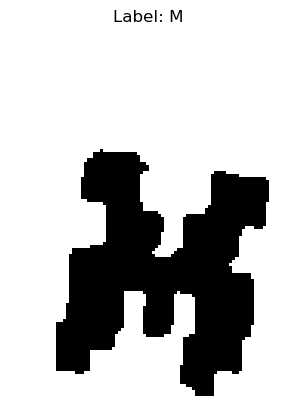

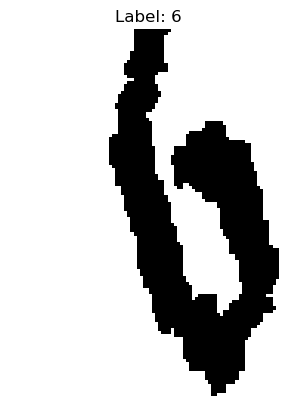

Epoch 1, Train Loss: 3.1042, Val Loss: 2.8105
Epoch 2, Train Loss: 2.4021, Val Loss: 1.9146
Epoch 3, Train Loss: 1.8674, Val Loss: 1.4891
Epoch 4, Train Loss: 1.5861, Val Loss: 1.3009
Epoch 5, Train Loss: 1.3777, Val Loss: 1.0658
Epoch 6, Train Loss: 1.2528, Val Loss: 0.9227
Epoch 7, Train Loss: 1.1468, Val Loss: 0.8592
Epoch 8, Train Loss: 1.0747, Val Loss: 0.7974
Epoch 9, Train Loss: 1.0093, Val Loss: 0.7802
Epoch 10, Train Loss: 0.9510, Val Loss: 0.7339
Epoch 11, Train Loss: 0.9086, Val Loss: 0.6868
Epoch 12, Train Loss: 0.8666, Val Loss: 0.6743
Epoch 13, Train Loss: 0.8386, Val Loss: 0.6470
Epoch 14, Train Loss: 0.8028, Val Loss: 0.6242
Epoch 15, Train Loss: 0.7683, Val Loss: 0.6012
Epoch 16, Train Loss: 0.7410, Val Loss: 0.5882
Epoch 17, Train Loss: 0.7248, Val Loss: 0.5629
Epoch 18, Train Loss: 0.7007, Val Loss: 0.5494
Epoch 19, Train Loss: 0.6797, Val Loss: 0.5321
Epoch 20, Train Loss: 0.6735, Val Loss: 0.5502
Epoch 21, Train Loss: 0.6483, Val Loss: 0.5153
Epoch 22, Train Loss: 

In [66]:
# Initialize the model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = CNN(num_classes).to(device)

batch_size = 32
full_dataset = SegmentDataset("./train_ez/", image_size, char_to_label, transform=None)
total_len = len(full_dataset)
val_percent = 0.15
val_len = int(total_len * val_percent)
train_len = total_len - val_len

train_indices, val_indices = torch.utils.data.random_split(range(total_len), [train_len, val_len])

class SubsetWithTransform(Dataset):
    def __init__(self, subset, base_dataset, transform):
        self.subset = subset
        self.base_dataset = base_dataset
        self.transform = transform
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        base_idx = self.subset[idx]
        img_tensor, label_tensor = self.base_dataset[base_idx]
        img = img_tensor.squeeze().numpy().astype(np.uint8) * 255
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = torch.from_numpy(img_tensor)
        return img, label_tensor

train_dataset = SubsetWithTransform(train_indices, full_dataset, transform_train)
val_dataset = SubsetWithTransform(val_indices, full_dataset, transform_eval)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# # Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

import matplotlib.pyplot as plt

# Visualize first 10 samples from train_dataset
for i in range(10):
    img_tensor, label = train_dataset[i]
    img = img_tensor.squeeze().numpy()   # Shape (H, W)
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {alphanum[label]}")
    plt.axis('off')
    plt.show()

for epoch in range(50):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device).float()  # Ensures tensor is float32 and on same device as model
        y_batch = y_batch.to(device)          # Labels also on device
        y_batch = y_batch.long()
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.long()
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    # Save model & optimizer, and optionally current epoch
    checkpoint = {
        'epoch': epoch,  # current epoch integer
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss
    }
    torch.save(checkpoint, 'checkpoint.pth')
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')




In [59]:
#continue training
# Resume if checkpoint exists
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

model = CNN(num_classes).to(device)


checkpoint_path = 'checkpoint.pth'
if os.path.isfile(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    print(f"Resuming from epoch {start_epoch}")
else:
    start_epoch = 0
    print("Starting from scratch.")

# ==== TRAINING LOOP ====
criterion = nn.CrossEntropyLoss()
num_epochs = 50  # total epochs you want to train for

for epoch in range(start_epoch, num_epochs):
    # ---- Training ----
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device).float()  # Ensures tensor is float32 and on same device as model
        y_batch = y_batch.to(device)          # Labels also on device
        y_batch = y_batch.long()
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # ---- Validation ----
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device).float()
            y_batch = y_batch.long()
            y_batch = y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)

    # ---- Checkpoint Saving ----
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss
    }
    torch.save(checkpoint, checkpoint_path)
    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# ==== OPTIONAL: VISUALIZE FIRST 10 SAMPLES ====
for i in range(10):
    img_tensor, label = train_dataset[i]
    img = img_tensor.squeeze().numpy()
    plt.imshow(img, cmap='gray')
    plt.title(f"Label: {alphanum[label]}")
    plt.axis('off')
    plt.show()

Using device: mps
Resuming from epoch 14
Epoch 15, Train Loss: 0.8840, Val Loss: 0.5361
Epoch 16, Train Loss: 0.8825, Val Loss: 0.5361
Epoch 17, Train Loss: 0.8759, Val Loss: 0.5361
Epoch 18, Train Loss: 0.8900, Val Loss: 0.5361
Epoch 19, Train Loss: 0.8762, Val Loss: 0.5361
Epoch 20, Train Loss: 0.8764, Val Loss: 0.5361
Epoch 21, Train Loss: 0.8789, Val Loss: 0.5361


KeyboardInterrupt: 

In [67]:
# Example prediction
# Load test data and ground-truth labels in the same way
test_dataset = SegmentDataset("./clean_test/", image_size, char_to_label)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])


model.eval()
test_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.long()
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()
avg_test_loss = test_loss / len(test_loader)
print(f'Test loss: {avg_test_loss:.4f}')

correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)  # Get index of max log-probability
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)
print(f'Test accuracy: {correct / total:.2%}')

Test loss: 0.4131
Test accuracy: 87.89%


In [81]:
import glob
import os

total_words = 0
correct_words = 0

test_files = glob.glob(os.path.join('./clean_test/', '*.*'))
for file in test_files:
    image = cv2.imread(file)
    label_str = get_label_from_filename(file)   # Actual word string

    resized, segments = get_segments(image)
    predicted_chars = []
    for idx, seg in enumerate(segments):
        segment_img = resized[:, seg[0]:seg[1]+1]
        segment_img = cv2.cvtColor(segment_img, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(segment_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        segment_img = cv2.resize(binary, image_size)
        img_tensor = torch.from_numpy(segment_img).float() / 255.0
        img_tensor = img_tensor.unsqueeze(0).unsqueeze(0) # shape [1,1,H,W]
        with torch.no_grad():
            img_tensor = img_tensor.to(device)
            output = model(img_tensor)
            _, predicted_label = torch.max(output, 1)
        predicted_char = alphanum[predicted_label.item()]
        predicted_chars.append(predicted_char)

    pred_str = ''.join(predicted_chars).lower()
    mark = "O" if pred_str == label_str else "X"
    print(f"{mark}: Predicted '{pred_str}' | True '{label_str}'")

    total_words += 1
    if pred_str == label_str:
        correct_words += 1

print(f"\nTotal: {correct_words}/{total_words} correct words. Accuracy: {correct_words/total_words:.2%}")

X: Predicted 'm6' | True 'xzrf2'
O: Predicted '845ios' | True '845ios'
O: Predicted 'kjlcnst' | True 'kjlcnst'
X: Predicted 'mwk' | True 'hc0ulqk'
O: Predicted 'muqa445' | True 'muqa445'
X: Predicted '3j61hll' | True '3j61hli'
O: Predicted 's29j' | True 's29j'
O: Predicted 'trejedm' | True 'trejedm'
X: Predicted '711y14h' | True '7iiyi4h'
X: Predicted 'qfvkwm7' | True 'qeltw3mx'
O: Predicted 'exz3r1y4' | True 'exz3r1y4'
O: Predicted '9o9vjrf' | True '9o9vjrf'
X: Predicted 'mo' | True '3n6o'
X: Predicted '7k7t' | True '9kat'
X: Predicted 'gpu' | True 'g4pu'
X: Predicted 'uwgjqz44' | True 'umgjqz44'
X: Predicted '1mr5u112' | True 'imr5u172'
O: Predicted 'ta77ta' | True 'ta77ta'
O: Predicted '6b8qqt' | True '6b8qqt'
O: Predicted 'n4oomt' | True 'n4oomt'
X: Predicted 'k7nk7a9' | True 'f5rf7a9'
X: Predicted 'ui331hgj' | True 'uj33lkgd'
X: Predicted 'xgyfahj' | True 'xgyfaku'
X: Predicted 'fq' | True 'f1r4t'
X: Predicted 'wfw6' | True 'wfs6q4ag'
O: Predicted '4ofpfnr' | True '4ofpfnr'
O: Pre

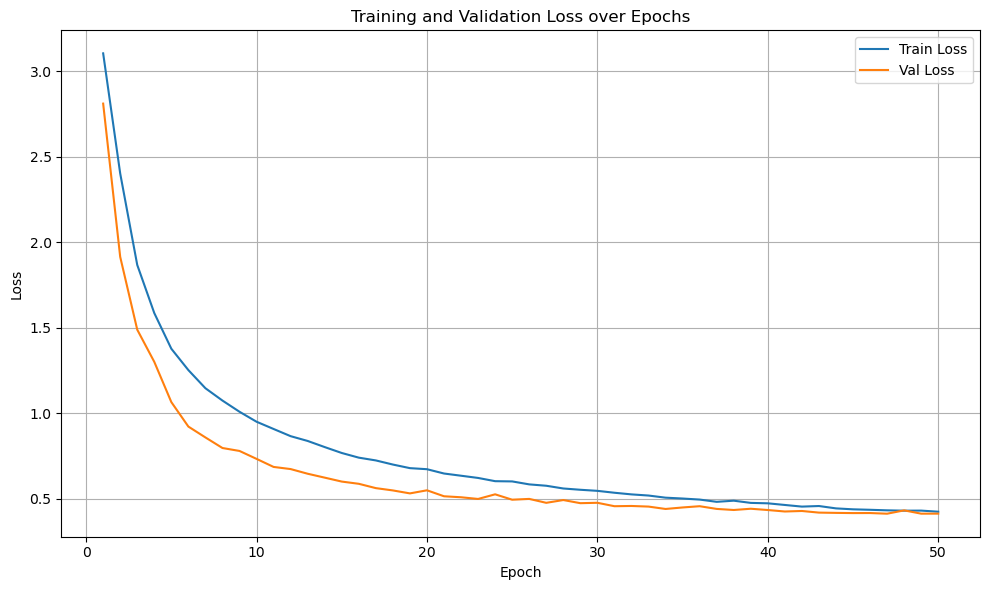

In [3]:

# Epoch 1, Train Loss: 3.1042, Val Loss: 2.8105
# Epoch 2, Train Loss: 2.4021, Val Loss: 1.9146
# Epoch 3, Train Loss: 1.8674, Val Loss: 1.4891
# Epoch 4, Train Loss: 1.5861, Val Loss: 1.3009
# Epoch 5, Train Loss: 1.3777, Val Loss: 1.0658
# Epoch 6, Train Loss: 1.2528, Val Loss: 0.9227
# Epoch 7, Train Loss: 1.1468, Val Loss: 0.8592
# Epoch 8, Train Loss: 1.0747, Val Loss: 0.7974
# Epoch 9, Train Loss: 1.0093, Val Loss: 0.7802
# Epoch 10, Train Loss: 0.9510, Val Loss: 0.7339
# Epoch 11, Train Loss: 0.9086, Val Loss: 0.6868
# Epoch 12, Train Loss: 0.8666, Val Loss: 0.6743
# Epoch 13, Train Loss: 0.8386, Val Loss: 0.6470
# Epoch 14, Train Loss: 0.8028, Val Loss: 0.6242
# Epoch 15, Train Loss: 0.7683, Val Loss: 0.6012
# Epoch 16, Train Loss: 0.7410, Val Loss: 0.5882
# Epoch 17, Train Loss: 0.7248, Val Loss: 0.5629
# Epoch 18, Train Loss: 0.7007, Val Loss: 0.5494
# Epoch 19, Train Loss: 0.6797, Val Loss: 0.5321
# Epoch 20, Train Loss: 0.6735, Val Loss: 0.5502
# Epoch 21, Train Loss: 0.6483, Val Loss: 0.5153
# Epoch 22, Train Loss: 0.6354, Val Loss: 0.5095
# Epoch 23, Train Loss: 0.6224, Val Loss: 0.4996
# Epoch 24, Train Loss: 0.6035, Val Loss: 0.5267
# Epoch 25, Train Loss: 0.6021, Val Loss: 0.4952
# Epoch 26, Train Loss: 0.5848, Val Loss: 0.4999
# Epoch 27, Train Loss: 0.5768, Val Loss: 0.4770
# Epoch 28, Train Loss: 0.5608, Val Loss: 0.4933
# Epoch 29, Train Loss: 0.5533, Val Loss: 0.4749
# Epoch 30, Train Loss: 0.5470, Val Loss: 0.4772
# Epoch 31, Train Loss: 0.5359, Val Loss: 0.4572
# Epoch 32, Train Loss: 0.5263, Val Loss: 0.4586
# Epoch 33, Train Loss: 0.5196, Val Loss: 0.4550
# Epoch 34, Train Loss: 0.5071, Val Loss: 0.4411
# Epoch 35, Train Loss: 0.5021, Val Loss: 0.4499
# Epoch 36, Train Loss: 0.4960, Val Loss: 0.4572
# Epoch 37, Train Loss: 0.4828, Val Loss: 0.4414
# Epoch 38, Train Loss: 0.4895, Val Loss: 0.4351
# Epoch 39, Train Loss: 0.4766, Val Loss: 0.4424
# Epoch 40, Train Loss: 0.4741, Val Loss: 0.4349
# Epoch 41, Train Loss: 0.4645, Val Loss: 0.4263
# Epoch 42, Train Loss: 0.4549, Val Loss: 0.4293
# Epoch 43, Train Loss: 0.4583, Val Loss: 0.4198
# Epoch 44, Train Loss: 0.4445, Val Loss: 0.4182
# Epoch 45, Train Loss: 0.4390, Val Loss: 0.4170
# Epoch 46, Train Loss: 0.4363, Val Loss: 0.4173
# Epoch 47, Train Loss: 0.4331, Val Loss: 0.4134
# Epoch 48, Train Loss: 0.4311, Val Loss: 0.4329
# Epoch 49, Train Loss: 0.4315, Val Loss: 0.4136
# Epoch 50, Train Loss: 0.4251, Val Loss: 0.4138

import matplotlib.pyplot as plt


epochs = list(range(1, 51))
train_loss = [3.1042, 2.4021, 1.8674, 1.5861, 1.3777, 1.2528, 1.1468, 1.0747, 1.0093, 0.9510,
              0.9086, 0.8666, 0.8386, 0.8028, 0.7683, 0.7410, 0.7248, 0.7007, 0.6797, 0.6735,
              0.6483, 0.6354, 0.6224, 0.6035, 0.6021, 0.5848, 0.5768, 0.5608, 0.5533, 0.5470,
              0.5359, 0.5263, 0.5196, 0.5071, 0.5021, 0.4960, 0.4828, 0.4895, 0.4766, 0.4741,
              0.4645, 0.4549, 0.4583, 0.4445, 0.4390, 0.4363, 0.4331, 0.4311, 0.4315, 0.4251]

val_loss = [2.8105, 1.9146, 1.4891, 1.3009, 1.0658, 0.9227, 0.8592, 0.7974, 0.7802, 0.7339,
            0.6868, 0.6743, 0.6470, 0.6242, 0.6012, 0.5882, 0.5629, 0.5494, 0.5321, 0.5502,
            0.5153, 0.5095, 0.4996, 0.5267, 0.4952, 0.4999, 0.4770, 0.4933, 0.4749, 0.4772,
            0.4572, 0.4586, 0.4550, 0.4411, 0.4499, 0.4572, 0.4414, 0.4351, 0.4424, 0.4349,
            0.4263, 0.4293, 0.4198, 0.4182, 0.4170, 0.4173, 0.4134, 0.4329, 0.4136, 0.4138]

plt.figure(figsize=(10,6))
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()